## Importación de Librerías

In [78]:
import pandas as pd
import numpy as np
# Visualización de datos
import matplotlib.pyplot as plt
import seaborn as sns

## Carga de datos

In [37]:
df = pd.read_csv('../data/raw/autorenew.csv', parse_dates=['dateCrawled', 'dateCreated', 'lastSeen']) 

In [38]:
df.head()

,dateCrawled,name,seller,offerType,price,vehicleType,yearOfRegistration,gearbox,powerCV,model,kilometer,monthOfRegistration,fuelType,brand,notRepairedDamage,dateCreated,nrOfPictures,postalCode,lastSeen
0,2016-03-24 11:52:17,Golf_3_1.6,private,offer,480,NaN,1993,manually,0.0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,A5_Sportback_2.7_Tdi,private,offer,18300,coupe,2011,manually,187.0,NaN,125000,5,diesel,audi,yes,2016-03-24,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,"Jeep_Grand_Cherokee_""Overland""",private,offer,9800,suv,2004,automatic,161.0,grand,125000,8,diesel,jeep,NaN,2016-03-14,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,GOLF_4_1_4__3TÜRER,private,offer,1500,small car,2001,manually,74.0,golf,150000,6,petrol,volkswagen,no,2016-03-17,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,Skoda_Fabia_1.4_TDI_PD_Classic,private,offer,3600,small car,2008,manually,68.0,fabia,90000,7,diesel,skoda,no,2016-03-31,0,60437,2016-04-06 10:17:21


## Selección de columnas

Vamos a eliminar columnas que no nos aporten información relevante para nuestro análisis

### Eliminar duplicados

In [39]:
df = df.drop_duplicates()

In [40]:
df.columns

Index(['dateCrawled', 'name', 'seller', 'offerType', 'price', 'vehicleType',
       'yearOfRegistration', 'gearbox', 'powerCV', 'model', 'kilometer',
       'monthOfRegistration', 'fuelType', 'brand', 'notRepairedDamage',
       'dateCreated', 'nrOfPictures', 'postalCode', 'lastSeen'],
      dtype='object')

In [41]:
columnas_eliminar = {
     'dateCrawled',
     'dateCreated',
     'lastSeen',
     'seller',
     'offerType',
     'model',
     'monthOfRegistration',
     'nrOfPictures',
     'postalCode'
}

In [42]:
df = df.drop(columns=columnas_eliminar)

In [43]:
df.duplicated().sum()

np.int64(11622)

Observamos que puede haber duplicados ya que se trate de diferentes unidades del mismo vehículo. Como no tenemos un identificador único como un ID los vamos a dejar.

## Limpieza

Vamos a ir columna por columna

In [44]:
df.columns

Index(['name', 'price', 'vehicleType', 'yearOfRegistration', 'gearbox',
       'powerCV', 'kilometer', 'fuelType', 'brand', 'notRepairedDamage'],
      dtype='object')

### Columna `price`

In [45]:
print(f"El porcentaje de valores nulos de la columna price es: {df['price'].isnull().sum()}")

El porcentaje de valores nulos de la columna price es: 0


Como no tiene valoresnulos,procedemos a ver qué proporción de vehículos está debajo de cierto umbral. Por ejemplo estaleceremos un umbral de 100(€ presumiblemente)

In [46]:
umbral_precio_inferior = 100
porcentaje_baratos = (df['price'] < umbral_precio_inferior).mean() * 100
print(f"El porcentaje de vehículos por debajo de {umbral_precio_inferior} es: {round(porcentaje_baratos, 2)} %")

El porcentaje de vehículos por debajo de 100 es: 3.59 %


Los datos por debajo de 100 son probablemente erróneos y representan el 3,59 % por lo que es razonable eliminarlos

A continuación , hacemos lo mismo con un umbral superior a 4M

In [47]:
umbral_precio_superior = 4e6 # esto quiere decir 4M
porcentaje_caros = (df['price'] > umbral_precio_superior).mean() * 100
print(f"El porcentaje de vehículos por encima de {umbral_precio_superior} es: {round(porcentaje_caros, 3)} %")

El porcentaje de vehículos por encima de 4000000.0 es: 0.014 %


Vamos a revisarlo manualmente para ver si tiene sentido

In [48]:
df[df['price'] > umbral_precio_superior].sample(5) # es un filtro y por eso va entre corchetes(no es algo que se mencione antes de por qué pongo df[df[col]])

,name,price,vehicleType,yearOfRegistration,gearbox,powerCV,kilometer,fuelType,brand,notRepairedDamage
185227,Suche_fuer_mein_golf,11111111,NaN,2000,NaN,0.0,5000,NaN,volkswagen,NaN
366653,BMW_E36_Cabrio_tausch_gegen_ein_Opel_Insignia,99999999,convertible,1996,manually,189.0,150000,NaN,bmw,NaN
121793,Alter_VW_Kaefer_Scheunenfund,10000000,NaN,1910,NaN,0.0,100000,NaN,volkswagen,NaN
127769,Golf_4_laesst_sich_nicht_oeffnen,11111111,NaN,2003,manually,74.0,125000,petrol,volkswagen,NaN
87799,Leasinguebernahme,27322222,NaN,2014,manually,161.0,40000,diesel,citroen,NaN


Tras revisar los datos podemos concluir que todos los registros superiores a 4M son erróneos

In [50]:
filtro_precio = (df['price'] < umbral_precio_superior) & (df['price'] > umbral_precio_inferior)
df = df[filtro_precio]

### Columna `yearOfRegistration` 

Tal como vimos con las columnas de fechas de los anuncios, los registros no pueden ser de después de 2016. Sin embargo, vamos a comprobar entradas posteriores a este año.

In [54]:
df[df['yearOfRegistration'] > 2016]['yearOfRegistration'].value_counts().head(7)

yearOfRegistration
2017    9925
2018    3797
2019      15
9999      14
5000      14
6000       6
9000       4
Name: count, dtype: int64

Como vemos, tiene sentido que los años de resgitro correspondan a 2017 y 2018 y es posible que 2019. A parte de eso, el resto de datos son muy probablemente erróneos. ASí que podemos eliminarlos o tratarlos como nulos.

In [56]:
# Nos quedamos con las entradas que sean anteriores a 2019
df = df[df['yearOfRegistration'] < 2019]

Veamos qué ocurre ahora con las fechas muy antiguas. Establezcamos un umbral de 1950.

In [63]:
umbral_fecha = 1950
df[df['yearOfRegistration'] < umbral_fecha]['yearOfRegistration'].value_counts().head()

yearOfRegistration
1910    36
1000    23
1937    12
1938     8
1929     7
Name: count, dtype: int64

Vemos que hay 36 registros de 1910 que probablemente se traten de errores. Vamos a ver la distribución gráfica más detallada.

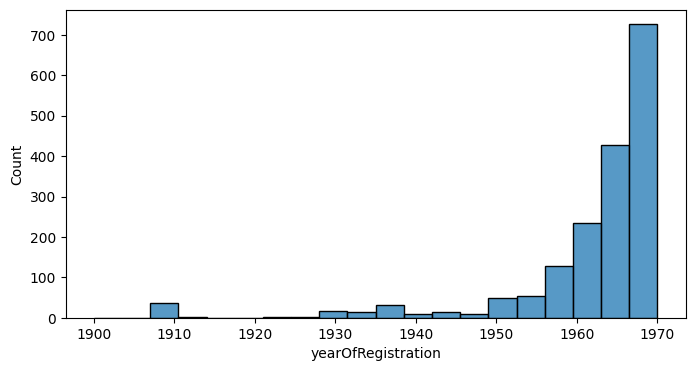

In [65]:
plt.figure(figsize=(8, 4))

sns.histplot(df['yearOfRegistration'], bins=20, binrange=(1900, 1970))
plt.show()

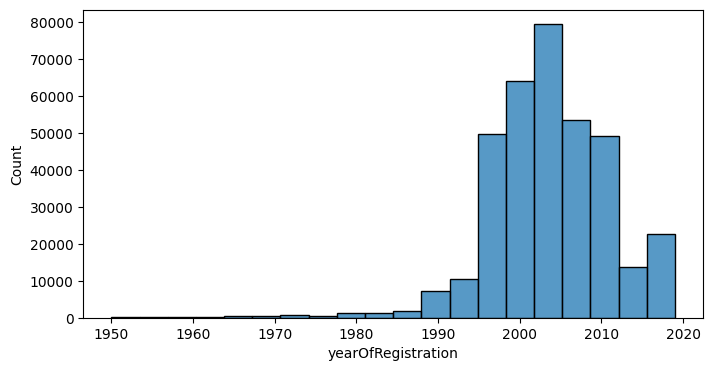

In [66]:
plt.figure(figsize=(8, 4))

sns.histplot(df['yearOfRegistration'], bins=20, binrange=(umbral_fecha, 2019))
plt.show()

Podemos examinar manualmente las entradas más antiguas para comprobar si realmente son errores.

In [67]:
df[df['yearOfRegistration'] < umbral_fecha].sample(5)

,name,price,vehicleType,yearOfRegistration,gearbox,powerCV,kilometer,fuelType,brand,notRepairedDamage
17320,Andere_Adler_Trumpf_1_7_AV___sehr_selten__top_...,32000,NaN,1933,manually,37.0,5000,petrol,sonstige_autos,no
292105,VW_Golf_2_19E_1.8_90ps_neu_ueberholter_Motor_,450,NaN,1500,manually,0.0,5000,NaN,volkswagen,yes
56160,Polo_86c_TÜV_01.17__sofort_fahrbereit__auch_Ta...,330,NaN,1000,NaN,0.0,5000,NaN,volkswagen,NaN
16859,Ford_mondeo_mk3_2.0tdc?_tubo_lader,190,NaN,1000,NaN,0.0,5000,NaN,ford,NaN
286776,Suche_Menschen_mit_Herz_und_Auto_;_,2500,NaN,1910,NaN,0.0,5000,NaN,volkswagen,NaN


Los datos no tienen mucho sentido ni nos aportan información. Vamos a eliminarlas. También podríamos convertir su año a nulo y luego gestionarlo, pero al ser pocas y tener tan poca información no nos compensa.

In [69]:
# Nos quedamos con las entradas que sean posteriores a 1950
df = df[df['yearOfRegistration'] > umbral_fecha]

### Columna `powerCV`

Un vehículo con potencia mayor a 1200 CV prácticamente no existe. Además, es muy poco frecuente encontrarlo en el rango entre 550CV y 1200CV. Veamos la distribución en este rango.

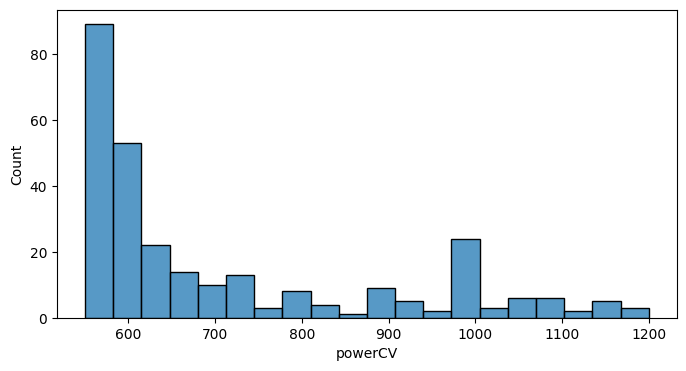

In [70]:
umbral_superior_cv = 550

plt.figure(figsize=(8, 4))

sns.histplot(df['powerCV'], bins=20, binrange=(umbral_superior_cv, 1200))
plt.show()

Nos vamos a quedar con los que son menores de 550CV

In [72]:
df = df[df['powerCV'] < umbral_superior_cv]

In [76]:
# Lo mismo con un umbral inferior de 40 CV
df[df['powerCV'] < 40].sample(5)

,name,price,vehicleType,yearOfRegistration,gearbox,powerCV,kilometer,fuelType,brand,notRepairedDamage
356190,Renault_Clio_2001,200,small car,2001,manually,0.0,150000,petrol,renault,yes
202802,Mercedes_Benz_E_220_CDI__mit_TÜV_Getriebeschaden,680,combi,1999,automatic,0.0,150000,diesel,mercedes_benz,yes
113410,NUR_NOCH_HEUTE___FORD_KA+_SOMMER_UND_WINTER_RE...,350,NaN,2016,manually,0.0,70000,petrol,ford,NaN
357332,Mercedes_A_klasse_1.6_eventtuel_tausch,1000,small car,1998,manually,0.0,150000,petrol,mercedes_benz,no
215580,Opel_Zafira_16_V,1200,bus,2000,manually,0.0,150000,NaN,opel,NaN


Vemos que hay muchas con valores de 0. Vamos a reemplazarlos por nulos porque se trata de una cantidad considerable.

In [79]:
df['powerCV'] = df['powerCV'].apply(lambda x: np.nan if x < 40 else x)